In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#data processing and adding a validation set

In [3]:
#configure to train on gpu. Comment out if you don't have a suitable gpu
gpuAvail = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs available: ", len(gpuAvail))
tf.config.experimental.set_memory_growth(gpuAvail[0], True)

Num GPUs available:  1


In [4]:
#no longer needed as data file structuring is done separately
# cwd = os.getcwd()
# print(cwd)
# dataPath = os.path.join(cwd, r"forestFireData\Data")
# os.chdir(dataPath)
# print(os.getcwd())
# if os.path.isdir('Valid_Data/Non_Fire') is False:
#     os.makedirs('Valid_Data/Non_Fire')
#     os.makedirs('Valid_Data/Fire')
#     os.chdir('forestFireData/Data/Train_Data/Non_Fire')
#     #moving part of train data into valid set
#     for i in random.sample(glob.glob('NF_*'), 90): #10% of train set
#         shutil.move(i, 'forestFireData/Data/Valid_Data/Non_Fire')
#     os.chdir("forestFireData/Data/Train_Data/Fire")
#     for i in random.sample(glob.glob('F_*.jpg'), 90):
#         shutil.move(i, 'forestFireData/Data/Valid_Data/Fire')   
# os.chdir('../../')
# print("current working directory after dataset manipulation:", os.getcwd())


In [5]:
print(os.getcwd())
train_path='forestFireData/Data/Train_Data'
valid_path='forestFireData/Data/Valid_Data'
test_path='forestFireData/Data/Test_Data'

C:\Users\hanso\Desktop\projects_desktop\ForestFireDetector


In [6]:
#image processing using vgg16 preprocess
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, target_size=(224,224), classes=['Fire', 'Non_Fire'], batch_size=10) #flow_from_dir(directory path, resize factor for all imgs, list of class subdirectory, batch size) 
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=valid_path, target_size=(224,224), classes=['Fire', 'Non_Fire'], batch_size=10, shuffle=False)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_path, target_size=(224,224), classes=['Fire', 'Non_Fire'], batch_size=10, shuffle=False)

Found 4126 images belonging to 2 classes.
Found 96 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [7]:
#populating labels
imgs, labels = next(train_batches)

In [8]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1,10,figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

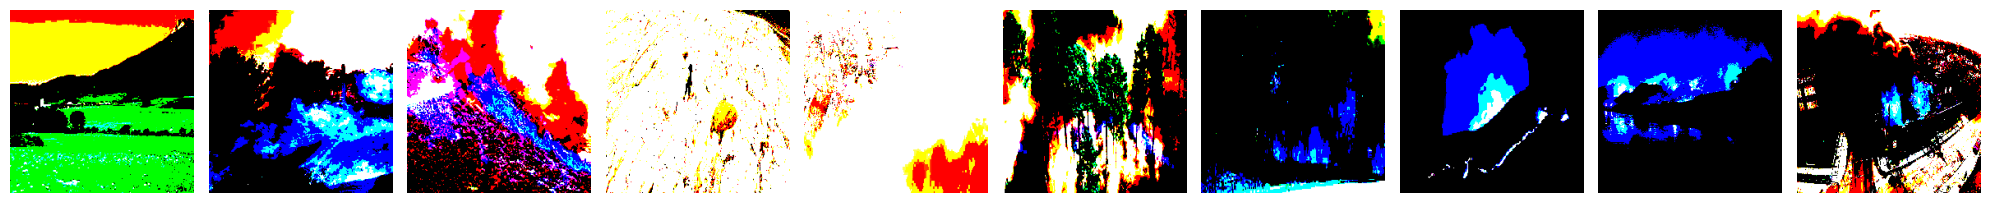

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [9]:
#previewing processed images, labels
plotImages(imgs)
print(labels)

In [10]:
#building the VGG16 model

In [11]:
model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', input_shape=(224,224, 3)),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2), strides=2),
    Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2), strides=2),
    Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2), strides=2),
    Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2), strides=2),
    Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2), strides=2),
    Flatten(),
    Dense(256, activation='relu',name='fc1'),
    Dense(128, activation='relu',name='fc2'),
    Dense(2, activation='softmax',name='output') #using softmax and 2 node as img labels are one-hot encoded, denoting multi-class
    
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) #implement early stopping to reduce overfitting
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy']) #use categorical cross for multi-class calssification

In [14]:
model.fit(x=train_batches, validation_data = valid_batches, epochs=15, verbose=2)
#note original dataset has some corrupted images might need to sift thorugh them if using the whole set

Epoch 1/15
413/413 - 60s - loss: 0.3253 - accuracy: 0.8834 - val_loss: 0.1904 - val_accuracy: 0.9375 - 60s/epoch - 145ms/step
Epoch 2/15
413/413 - 53s - loss: 0.1875 - accuracy: 0.9372 - val_loss: 0.4763 - val_accuracy: 0.9062 - 53s/epoch - 129ms/step
Epoch 3/15
413/413 - 53s - loss: 0.1534 - accuracy: 0.9469 - val_loss: 0.2285 - val_accuracy: 0.9479 - 53s/epoch - 129ms/step
Epoch 4/15
413/413 - 54s - loss: 0.1478 - accuracy: 0.9472 - val_loss: 0.2180 - val_accuracy: 0.9375 - 54s/epoch - 130ms/step
Epoch 5/15
413/413 - 54s - loss: 0.1304 - accuracy: 0.9583 - val_loss: 0.2130 - val_accuracy: 0.9375 - 54s/epoch - 130ms/step
Epoch 6/15
413/413 - 54s - loss: 0.1157 - accuracy: 0.9598 - val_loss: 0.1783 - val_accuracy: 0.9271 - 54s/epoch - 132ms/step
Epoch 7/15
413/413 - 54s - loss: 0.0970 - accuracy: 0.9627 - val_loss: 0.2025 - val_accuracy: 0.9271 - 54s/epoch - 131ms/step
Epoch 8/15
413/413 - 54s - loss: 0.0992 - accuracy: 0.9673 - val_loss: 0.2499 - val_accuracy: 0.9583 - 54s/epoch - 130

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

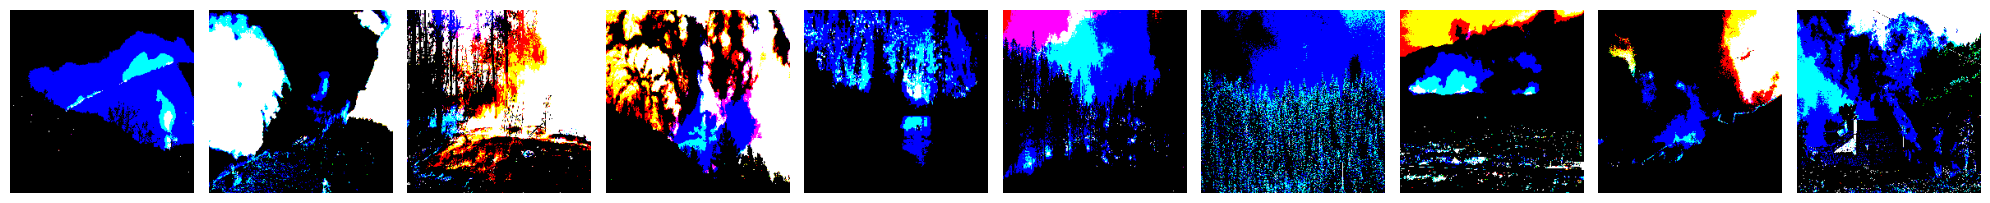

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [15]:
test_imgs, test_labels = next(test_batches) #preview the test images and their labels
plotImages(test_imgs)
print(test_labels)

In [16]:
predictions = model.predict(x=test_batches, verbose=2)

5/5 - 1s - 768ms/epoch - 154ms/step


In [17]:
cm=confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions,axis=-1))

In [18]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [19]:
test_batches.class_indices

{'Fire': 0, 'Non_Fire': 1}

Confusion matrix, without normalization
[[24  1]
 [ 4 21]]


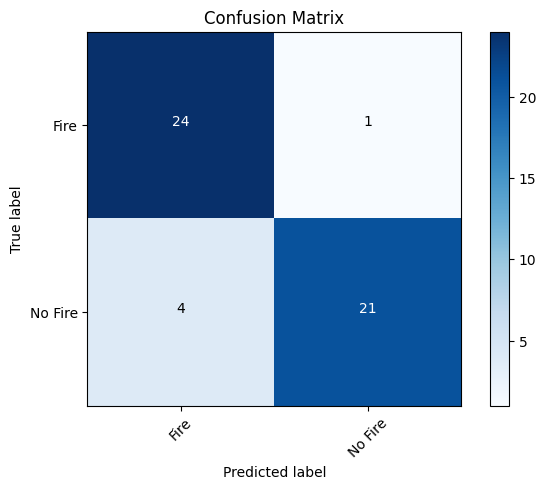

In [20]:
cm_plot_labels=['Fire','No Fire']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [21]:
from sklearn.metrics import accuracy_score
predicted_classes = np.argmax(predictions, axis=1)
true_labels = test_batches.classes
accuracy = accuracy_score(true_labels, predicted_classes)
print(f"Accuracy: {accuracy *100:.2f}%")

Accuracy: 90.00%
